# RQ4: Efficiency
We measure the efficiency of E-Test in terms of following metrics:
- [LLM prompt time](#llm-prompt-time)
- [RAG index time](#rag-index-time)
- [Consumed tokens](#consumed-tokens)

In [1]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# from huggingface_hub import login
from transformers import AutoTokenizer
import tiktoken
from ast import literal_eval
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
# hf_token = os.getenv("HUGGING_FACE_API_KEY")
# login(token=hf_token)

In [3]:
# Settings for plots
# plt.rcParams.update({"text.usetex": True, "font.family": "Times New Roman"})

In [4]:
EXPERIMENT_RESULTS_PATH = "../AutonomicTester/experiment_results"
RAW_EXPERIMENT_MODELS = [
    "GPT3.5Turbo",
    "FineTunedGPT3.5Turbo",
    "GPT4Turbo",
    "Llama3 8B",
    "Llama3 70B",
]
RAG_EXPERIMENT_MODELS = [
    "GPT3.5Turbo",
    "FineTunedGPT3.5Turbo",
    "GPT4Turbo",
    "Llama3 8B",
    "Llama3.3 70B",
]
TOKENIZER_MAP = {
    "GPT": tiktoken.get_encoding("cl100k_base").encode,
    "Llama3": AutoTokenizer.from_pretrained("../meta-llama-Llama-3.2-1B").tokenize,
}
PLOT_DATA_PATH = "plotdata"
TEST_SUITE_STATS_PATH = "plotdata/test_suite_stats.jsonl"
COVERAGE_TIMING_PATH = "plotdata/coverage_timing.csv"
MODEL_SECONDS_PATH = "plotdata/model_seconds.json"
FILTERED_SCENARIOS_PATH = "plotdata/filtered_scenarios.csv"
COUNT_METRICS_PATH = "plotdata/count_metrics.csv"
LARGE_TEST_SUITE_PATH = "plotdata/large_test_suite.csv"
LABELS = ["similar", "fixed", "buggy"]
FORMAL_LABELS = ["already-tested", "need-test", "error-prone"]

In [5]:
# Colors for plots
DARK_GREEN = "#1e8449"
DARK_BLUE = "#2874a6"

In [6]:
df_filtered_scenarios = pd.read_csv(FILTERED_SCENARIOS_PATH)
df_test_suite_stats = pd.read_json(TEST_SUITE_STATS_PATH, lines=True)
df_test_suite_stats["bug"] = df_test_suite_stats["bug"].astype(int)

## LLM Prompt Time
- GPT models
- GPT models with RAG
- Llama3 models
- Llama3 models with RAG

In [7]:
def read_rag_experiment_seconds(
    experiment_path: str, df_filtered_scenarios: pd.DataFrame
) -> list:
    """Read elapsed seconds for each scenario during the experiment."""
    experiment_seconds = []
    for file in os.listdir(experiment_path):
        if file.startswith("prompt_") and file.endswith(".jsonl"):
            match = re.match(r"prompt_([a-zA-Z]+)_(\d+).jsonl", file)
            cur_project = match.group(1)
            cur_bug = int(match.group(2))
            with open(os.path.join(experiment_path, file)) as f:
                for line in f:
                    prompt_detail = json.loads(line.strip())
                    cur_scenario_index = prompt_detail["scenario_index"]
                    if df_filtered_scenarios.query(
                        f"(project == '{cur_project}') & (bug == {cur_bug}) & (scenario_index == {cur_scenario_index})"
                    ).empty:
                        continue
                    elapsed_seconds = (
                        sum(
                            [q["elapsed_nanoseconds"] for q in prompt_detail["queries"]]
                        )
                        / 1_000_000_000
                    )
                    experiment_seconds.append(elapsed_seconds)
    return experiment_seconds


def read_time_raw_models() -> dict:
    # Read elapsed seconds for each LLM
    model_seconds = {}
    for model in RAW_EXPERIMENT_MODELS:
        model_path = os.path.join(EXPERIMENT_RESULTS_PATH, "vanilla", model)
        experiment_seconds = []
        for experiment in os.listdir(model_path):
            experiment_path = os.path.join(model_path, experiment)
            # Skip not directories
            if not os.path.isdir(experiment_path):
                continue
            df_stats = pd.read_csv(os.path.join(experiment_path, "statistics.csv"))
            df_stats["elapsed_seconds"] = (
                df_stats["elapsed_nanoseconds"] / 1_000_000_000
            )
            experiment_seconds += df_stats["elapsed_seconds"].to_list()
        model_seconds[model] = experiment_seconds
    return model_seconds


def read_time_rag_models(df_filtered_scenarios: pd.DataFrame) -> dict:
    # Read elapsed seconds for each LLM
    model_seconds = {}
    for model in RAG_EXPERIMENT_MODELS:
        model_path = os.path.join(EXPERIMENT_RESULTS_PATH, "rag", model)
        experiment_seconds = []
        for experiment in os.listdir(model_path):
            experiment_path = os.path.join(model_path, experiment)
            # Skip not directories
            if not os.path.isdir(experiment_path):
                continue
            experiment_seconds += read_rag_experiment_seconds(
                experiment_path, df_filtered_scenarios
            )
        model_seconds[model] = experiment_seconds
    return model_seconds

In [8]:
df_coverage_timing = pd.read_csv(COVERAGE_TIMING_PATH)
df_coverage_timing["elapsed_seconds"] = (
    df_coverage_timing["elapsed_nanoseconds"] / 1_000_000_000
)
df_coverage_timing["elapsed_seconds"].describe()

count    835.000000
mean      40.836375
std       35.315425
min        5.121730
25%        9.921499
50%       19.972091
75%       73.522073
max      168.136707
Name: elapsed_seconds, dtype: float64

In [9]:
if os.path.exists(MODEL_SECONDS_PATH):
    with open(MODEL_SECONDS_PATH) as f:
        model_seconds = json.load(f)
        raw_model_seconds = model_seconds["raw_model_seconds"]
        rag_model_seconds = model_seconds["rag_model_seconds"]
else:
    raw_model_seconds = read_time_raw_models()
    rag_model_seconds = read_time_rag_models(df_filtered_scenarios)
    # Save plot data if not exists
    with open(MODEL_SECONDS_PATH, "w") as f:
        model_seconds = {
            "raw_model_seconds": raw_model_seconds,
            "rag_model_seconds": rag_model_seconds,
        }
        json.dump(model_seconds, f)

In [10]:
def draw_time_boxplot_with_coverage(
    comparison_pairs: list,
    raw_model_seconds: dict,
    rag_model_seconds: dict,
    elapsed_seconds: list,
):
    fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
    numbersize = 21
    textsize = 22
    raw_seconds = [raw_model_seconds[raw_model] for raw_model, _, _ in comparison_pairs]
    rag_seconds = [rag_model_seconds[rag_model] for _, rag_model, _ in comparison_pairs]

    raw_medians = [np.median(data) for data in raw_seconds]
    rag_medians = [np.median(data) for data in rag_seconds]
    width = 0.4
    positions = np.arange(len(comparison_pairs) + 1) * 2
    distance = 0.9 * width
    raw_positions = positions[:-1] - distance
    rag_positions = positions[:-1] + distance
    raw_boxplot = ax.boxplot(
        raw_seconds,
        positions=raw_positions,
        widths=width,
        showfliers=False,
        label="prompt without RAG",
        patch_artist=True,
    )
    for patch in raw_boxplot["boxes"]:
        patch.set_facecolor(DARK_GREEN)
    rag_boxplot = ax.boxplot(
        rag_seconds,
        positions=rag_positions,
        widths=width,
        showfliers=False,
        label="prompt with RAG",
        patch_artist=True,
    )
    for patch in rag_boxplot["boxes"]:
        patch.set_facecolor(DARK_BLUE)

    cov_boxplot = ax.boxplot(
        elapsed_seconds,
        positions=[positions[-1]],
        widths=width,
        showfliers=False,
        patch_artist=True,
    )
    for patch in cov_boxplot["boxes"]:
        patch.set_facecolor("tab:brown")

    # Add text annotation for the median value
    for i, median in enumerate(raw_medians):
        line = raw_boxplot["whiskers"][2 * i + 1]
        print(
            "RAW",
            raw_boxplot["whiskers"][2 * i].get_ydata(),
            raw_boxplot["whiskers"][2 * i + 1].get_ydata(),
        )
        ax.text(
            line.get_xdata()[-1],
            line.get_ydata()[-1],
            f"{median:.2f}",
            ha="center",
            va="bottom",
            fontsize=numbersize,
        )
    for i, median in enumerate(rag_medians):
        line = rag_boxplot["whiskers"][2 * i + 1]
        print(
            "RAG",
            rag_boxplot["whiskers"][2 * i].get_ydata(),
            rag_boxplot["whiskers"][2 * i + 1].get_ydata(),
        )
        ax.text(
            line.get_xdata()[-1],
            line.get_ydata()[-1],
            f"{median:.2f}",
            ha="center",
            va="bottom",
            fontsize=numbersize,
        )

    cov_line = cov_boxplot["whiskers"][1]
    cov_median = np.median(elapsed_seconds)
    print(
        "Coverage",
        cov_boxplot["whiskers"][0].get_ydata(),
        cov_boxplot["whiskers"][1].get_ydata(),
    )
    ax.text(
        cov_line.get_xdata()[-1],
        cov_line.get_ydata()[-1],
        f"{cov_median:.2f}",
        ha="center",
        va="bottom",
        fontsize=numbersize,
    )

    # Add the legend to the plot
    ax.legend(fontsize=textsize)
    labels = [model for _, _, model in comparison_pairs] + ["Coverage"]
    ax.set_xticks(positions)  # Center the ticks between the two boxes
    ax.set_xticklabels(labels, rotation=35, ha="right", fontsize=textsize)
    # ax.set_xlabel("Model", fontsize=textsize)
    ax.set_ylabel("Time (seconds)", fontsize=textsize)
    ax.tick_params(axis="y", labelsize=textsize)
    ax.set_ylim(top=cov_line.get_ydata()[-1] + 20)
    fig.savefig("images/time_boxplot.pdf", bbox_inches="tight")

RAW [0.960042 0.810282] [1.163068 1.467391]
RAW [1.0886775 0.839966 ] [1.465747 2.026674]
RAW [1.981134 1.535363] [2.4747025 3.201852 ]
RAW [3.17723645 1.42715663] [4.36599052 6.1314842 ]
RAW [13.46858133  6.56981687] [18.06885641 24.96650291]
RAG [3.27206905 2.51441605] [4.15869066 5.48321036]
RAG [4.05882044 3.11622674] [5.11775427 6.68907747]
RAG [4.86706006 3.5077096 ] [6.10805291 7.95604586]
RAG [2.70916216 1.51178623] [3.77018478 5.33914098]
RAG [8.80327003 2.64422071] [14.16676518 21.88813556]
Coverage [9.92149933 5.12173005] [ 73.52207341 168.13670708]


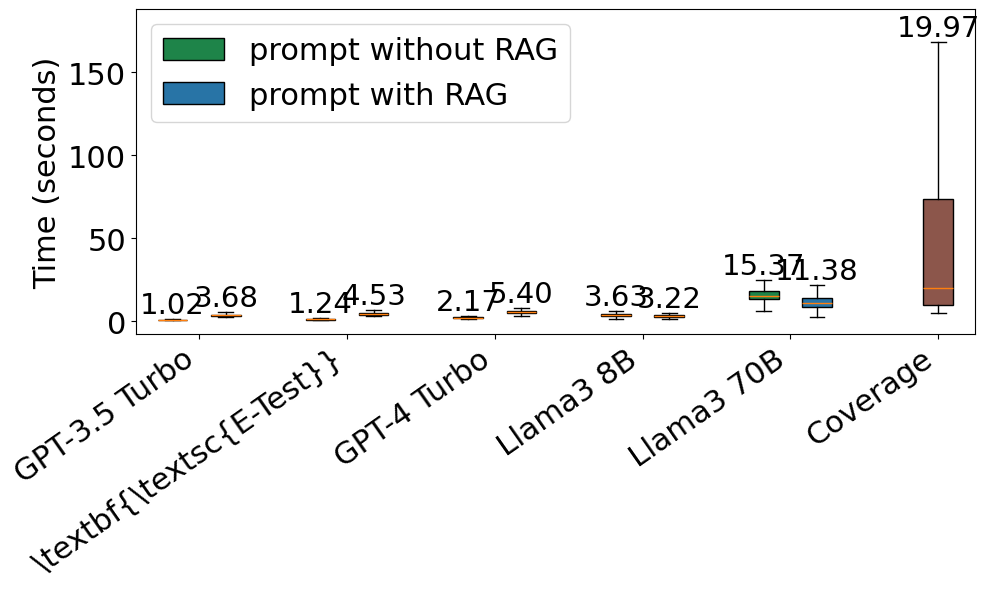

In [11]:
comparison_pairs = [
    ("GPT3.5Turbo", "GPT3.5Turbo", "GPT-3.5 Turbo"),
    ("FineTunedGPT3.5Turbo", "FineTunedGPT3.5Turbo", r"\textbf{\textsc{E-Test}}"),
    ("GPT4Turbo", "GPT4Turbo", "GPT-4 Turbo"),
    ("Llama3 8B", "Llama3 8B", "Llama3 8B"),
    ("Llama3 70B", "Llama3.3 70B", "Llama3 70B"),
]
draw_time_boxplot_with_coverage(
    comparison_pairs,
    raw_model_seconds,
    rag_model_seconds,
    df_coverage_timing["elapsed_seconds"].to_list(),
)

## RAG Index Time

In [12]:
def create_index_stats_dataframe(df_count_metrics: pd.DataFrame):
    stats = {"index_seconds": [], "num_loc": []}
    for model in RAG_EXPERIMENT_MODELS:
        if model == "Llama3.3 70B":
            model = "Llama3 70B"
        model_path = os.path.join(EXPERIMENT_RESULTS_PATH, "rag", model)
        for experiment in os.listdir(model_path):
            experiment_path = os.path.join(model_path, experiment)
            # Skip not directories
            if not os.path.isdir(experiment_path):
                continue
            target_scenario = experiment.split("_")[-1].upper()
            version = "b" if target_scenario in ["BUGGY", "SIMILAR"] else "f"
            summary_path = os.path.join(experiment_path, "summary.jsonl")
            with open(summary_path) as f:
                for line in f:
                    prompt_detail = json.loads(line.strip())
                    project = prompt_detail["project"]
                    bug = int(prompt_detail["bug"])
                    # Read index seconds and number of lines of code
                    index_seconds = prompt_detail["index_nanoseconds"] / 1_000_000_000
                    num_loc = df_count_metrics.query(
                        f"(project == '{project}') & (bug == {bug}) & (version == '{version}')"
                    )["num_lines"].iloc[0]
                    # Save stats
                    stats["index_seconds"].append(index_seconds)
                    stats["num_loc"].append(num_loc)
    return pd.DataFrame(stats)

In [13]:
df_count_metrics = pd.read_csv(COUNT_METRICS_PATH)
df_count_metrics["bug"] = df_count_metrics["bug"].astype(int)
df_index_stats = create_index_stats_dataframe(df_count_metrics)

In [14]:
avg_seconds_per_kline = (
    sum(df_index_stats["index_seconds"]) / sum(df_index_stats["num_loc"]) * 1000
)
print(
    f"Average seconds spent by RAG indexing per 1,000 lines of code: {avg_seconds_per_kline:.2f}"
)

Average seconds spent by RAG indexing per 1,000 lines of code: 0.24


## Consumed Tokens

In [15]:
def read_raw_consumed_tokens() -> pd.DataFrame:
    """Read consumed tokens using raw prompts into a DataFrame with columns [tokenizer, num_tokens]."""
    consumed_tokens = {"tokenizer": [], "num_tokens": []}
    for model in RAW_EXPERIMENT_MODELS:
        if model == "FineTunedGPT3.5Turbo":
            model_path = os.path.join(EXPERIMENT_RESULTS_PATH, "finetuning", model)
        else:
            model_path = os.path.join(EXPERIMENT_RESULTS_PATH, "vanilla", model)
        for experiment in os.listdir(model_path):
            experiment_path = os.path.join(model_path, experiment)
            # Skip not directories
            if not os.path.isdir(experiment_path):
                continue
            # Determine tokenizer
            if "GPT" in model:
                tokenizer = "GPT"
            elif "Llama3" in model:
                tokenizer = "Llama3"
            else:
                raise ValueError(f"Fail to determine tokenizer of model {model}!")
            df_stats = pd.read_csv(os.path.join(experiment_path, "statistics.csv"))
            df_stats["tokenizer"] = tokenizer
            consumed_tokens["tokenizer"] += df_stats["tokenizer"].to_list()
            consumed_tokens["num_tokens"] += df_stats["#tokens"].to_list()
    return pd.DataFrame(consumed_tokens)


def compute_rag_jsonl_tokens(
    experiment_path: str, df_filtered_scenarios: pd.DataFrame
) -> list:
    """Compute number of tokens for each RAG prompt scenario and return a list of {"tokenizer": xxx, "num_tokens_per_query": xxx, "num_tokens": xxx}."""
    consumed_tokens = []
    target_scenario = experiment_path.split("_")[-1].upper()
    # Determine tokenizer
    if "GPT" in experiment_path:
        tokenizer_name = "GPT"
        tokenizer = TOKENIZER_MAP["GPT"]
    elif "Llama3" in experiment_path:
        tokenizer_name = "Llama3"
        tokenizer = TOKENIZER_MAP["Llama3"]
    else:
        raise ValueError(
            f"Fail to determine tokenizer of experiment at {experiment_path}!"
        )
    # Iterate over each prompt detail file
    for file in os.listdir(experiment_path):
        if file.startswith("prompt_") and file.endswith(".jsonl"):
            match = re.match(r"prompt_([a-zA-Z]+)_(\d+).jsonl", file)
            cur_project = match.group(1)
            cur_bug = int(match.group(2))
            # Read jsonline file line by line
            with open(os.path.join(experiment_path, file)) as f:
                for line in f:
                    prompt_detail = json.loads(line.strip())
                    cur_scenario_index = prompt_detail["scenario_index"]
                    # Filter scenarios
                    if (
                        target_scenario != "SIMILAR"
                        and df_filtered_scenarios.query(
                            f"(project == '{cur_project}') & (bug == {cur_bug}) & (scenario_index == {cur_scenario_index})"
                        ).empty
                    ):
                        continue
                    # Compute number of tokens using tokenizer
                    num_tokens_per_query = []
                    for query_item in prompt_detail["queries"]:
                        num_tokens = len(tokenizer(query_item["prompt_str"]))
                        num_tokens_per_query.append(num_tokens)
                    consumed_tokens.append(
                        {
                            "tokenizer": tokenizer_name,
                            "num_tokens_per_query": num_tokens_per_query,
                            "num_tokens": sum(num_tokens_per_query),
                        }
                    )
    return consumed_tokens


def read_rag_consumed_tokens(df_filtered_scenarios: pd.DataFrame) -> pd.DataFrame:
    """Read consumed tokens using RAG prompts into a DataFrame with columns [tokenizer, num_tokens]."""
    consumed_tokens = []
    for model in RAG_EXPERIMENT_MODELS:
        if model == "Llama3.3 70B":
            model = "Llama3 70B"
        model_path = os.path.join(EXPERIMENT_RESULTS_PATH, "rag", model)
        for experiment in os.listdir(model_path):
            print(f"Counting tokens using model {model} in experiment {experiment}")
            experiment_path = os.path.join(model_path, experiment)
            # Skip not directories
            if not os.path.isdir(experiment_path):
                continue
            consumed_tokens += compute_rag_jsonl_tokens(
                experiment_path, df_filtered_scenarios
            )
    return pd.DataFrame(consumed_tokens)

In [16]:
# df_raw_tokens = read_raw_consumed_tokens()

In [17]:
# df_rag_tokens = read_rag_consumed_tokens(df_filtered_scenarios)

In [18]:
# df_raw_tokens.to_csv(os.path.join(PLOT_DATA_PATH, "raw_tokens.csv"), index=False)
# df_rag_tokens.to_csv(os.path.join(PLOT_DATA_PATH, "rag_tokens.csv"), index=False)

In [19]:
df_raw_tokens = pd.read_csv(os.path.join(PLOT_DATA_PATH, "raw_tokens.csv"))
df_rag_tokens = pd.read_csv(
    os.path.join(PLOT_DATA_PATH, "rag_tokens.csv"),
    converters={"num_tokens_per_query": literal_eval},
)

In [20]:
def draw_consumed_tokens_boxplot(
    df_raw_tokens: pd.DataFrame, df_rag_tokens: pd.DataFrame
):
    fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
    numbersize = 21
    fontsize = 22
    raw_data = [
        df_raw_tokens.query(f"tokenizer == '{tokenizer}'")["num_tokens"].values
        for tokenizer in TOKENIZER_MAP.keys()
    ]
    rag_data = [
        df_rag_tokens.query(f"tokenizer == '{tokenizer}'")["num_tokens"].values
        for tokenizer in TOKENIZER_MAP.keys()
    ]
    rag_per_query_data = [
        [
            v
            for values in df_rag_tokens.query(f"tokenizer == '{tokenizer}'")[
                "num_tokens_per_query"
            ].values
            for v in values
        ]
        for tokenizer in TOKENIZER_MAP.keys()
    ]

    raw_medians = [np.median(data) for data in raw_data]
    rag_medians = [np.median(data) for data in rag_data]
    rag_per_query_medians = [np.median(data) for data in rag_per_query_data]

    width = 0.2
    positions = np.arange(len(TOKENIZER_MAP.keys())) * 3.7
    distance = 1.5 * width

    raw_positions = positions - distance
    rag_per_query_positions = positions
    rag_positions = positions + distance

    for data, pos, label, color, medians in [
        (raw_data, raw_positions, "prompt without RAG", DARK_GREEN, raw_medians),
        (
            rag_per_query_data,
            rag_per_query_positions,
            "each query with RAG",
            "purple",
            rag_per_query_medians,
        ),
        (rag_data, rag_positions, "all queries with RAG", DARK_BLUE, rag_medians),
    ]:
        boxplot = ax.boxplot(
            data,
            positions=pos,
            widths=width,
            showfliers=False,
            label=label,
            patch_artist=True,
        )
        for patch in boxplot["boxes"]:
            patch.set_facecolor(color)
        # Add text annotation for the median value
        for i, median in enumerate(medians):
            line = boxplot["whiskers"][2 * i + 1]
            ax.text(
                line.get_xdata()[-1],
                line.get_ydata()[-1] + 350,
                f"{median:.0f}",
                ha="center",
                va="center",
                fontsize=numbersize,
            )
    # Add the legend to the plot
    ax.legend(loc="upper right", bbox_to_anchor=(0.885, 1), fontsize=22)
    ax.set_xticks(positions)  # Center the ticks between the two boxes
    ax.set_xticklabels(list(TOKENIZER_MAP.keys()))
    # ax.set_xlabel("Tokenizer", fontsize=fontsize)
    ax.set_ylabel("Consumed \#Tokens", fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_ylim(0, 13500)
    fig.savefig("images/consumed_tokens_boxplot.pdf", bbox_inches="tight")

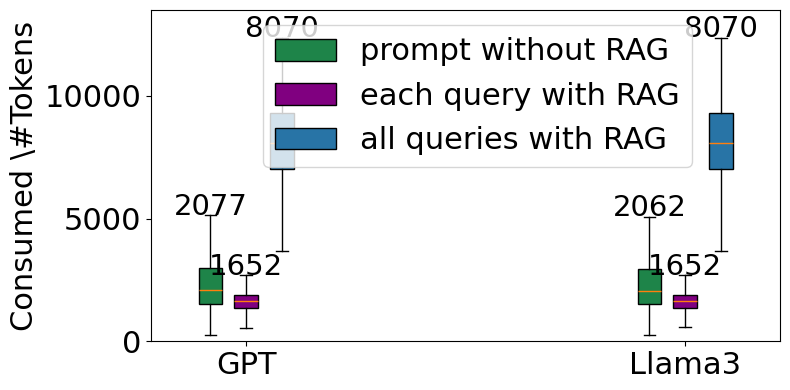

In [21]:
draw_consumed_tokens_boxplot(df_raw_tokens, df_rag_tokens)